In [1]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

%load_ext autoreload
%autoreload 2

# Cross testing of methods

In [2]:
#X, true_y = load_wine(return_X_y=True)
X, true_y = load_breast_cancer(return_X_y=True)
# X, true_y = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=250)

X = StandardScaler().fit_transform(X)

nc = 2
km = KMeans(n_clusters=nc)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float

n = 1
cfs = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    cfs.append(CounterfactualData([], index, target, label))

## Baseline

In [3]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 234 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (770) CFs (0)
Re-training surrogate model with data size: 770
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (14) Unique overall (14)
Generated random instances: (3723)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 790
Best instance score 0.0000 (X 0.9957 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 790
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (96) Unique overall (110)
Generated random instances: (3718)
Predicted top: 20 Counterfactuals: 1
Found new best [-1.29518759 -1.34165194  1.458227   -0.14704295 -0.28013707  0.47769099
  0.14942763  1.85901151  1.27037496 -0.5341362   1.00984614 -0.70170372
  1.22851549 -0.6

## Baycon

In [4]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

--- Executing... Initial Instance: 234 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (772) CFs (47)
Re-training surrogate model with data size: 772
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (17) Unique overall (17)
Generated random instances: (2246)
Predicted top: 20 Counterfactuals: 20
Found new best [ 1.16085577 -0.78646689 -1.30816094 -1.06736072 -0.83407899 -1.20286905
  1.6735895   0.30983525 -0.95150386  0.17470413 -0.68564905 -0.70170372
 -0.81732486 -0.60938309  1.53306919 -0.84271024 -0.66425839 -0.35250384
  0.39806995 -0.09641773 -1.1926276  -1.06128934 -1.23674413 -0.95750539
  0.79042275 -1.01219399 -0.96227999  1.48933846 -0.2325652  -0.12002053], with fitness score 0.2748 (X 0.93257 Y 0.34 F 0.86667), oversampling
Known alternatives: 792
Best instance score 0.2748 (X 0.93257 Y 0.34 F 0.86667), found on ep

## CFDE

In [5]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde_cfs

[CounterfactualData(cf=[array([-1.29518759,  0.47041462, -1.30816094,  0.84238292,  0.59076378,
        -1.20286905, -0.90746472,  1.1414004 ,  0.59687447,  0.24841954,
         0.8168073 , -0.70170372,  0.83704179,  0.78413429,  1.53306919,
         0.69153581,  0.63123632,  0.75800622,  0.39806995,  0.41473898,
        -1.1926276 ,  0.49306731, -1.23674413,  0.98350076,  0.59778105,
         0.95179839,  1.04461284,  1.13199171, -0.2325652 ,  0.62945686]), array([-1.29518759,  0.47041462, -1.30816094,  0.94479914,  0.59076378,
        -1.20286905, -0.90746472,  1.1414004 ,  0.47483474,  0.24841954,
         0.83154503, -0.70170372,  0.83704179,  0.78413429,  1.53306919,
         0.69153581,  0.63123632,  0.75800622,  0.39806995,  0.41473898,
        -1.1926276 ,  0.40544168, -1.23674413,  0.98350076,  0.59778105,
         0.95179839,  1.04461284,  1.13199171, -0.2325652 ,  0.62945686]), array([-1.29518759,  0.47041462, -1.30816094,  0.94479914,  0.59076378,
        -1.20286905, -0.90

## CFAE

In [6]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae_cfs

[CounterfactualData(cf=[array([ 0.92706194,  0.12059831,  0.96381838,  0.90244031, -0.83407899,
         0.7508258 , -0.90746472, -0.8318339 , -0.95150386,  0.17470413,
        -0.68564905, -0.70170372, -0.24731194, -0.60938309, -0.06178529,
         0.6549607 , -0.66425839, -0.35250384,  0.39806995, -0.09641773,
         1.0445982 ,  0.82098112,  1.235994  ,  1.0688194 ,  0.79042275,
         1.80072001,  0.56052069, -0.64539796, -0.2325652 , -0.12002053]), array([ 0.42585488, -0.78646689,  0.52386544,  0.32814017, -0.83407899,
         1.0300013 ,  1.07376795,  0.83685426,  0.8176282 ,  0.17470413,
        -0.68564905, -0.70170372, -0.81732486, -0.60938309,  1.53306919,
         1.3325485 ,  1.24018549,  1.23788236,  0.39806995,  0.40098279,
        -0.77788012, -1.06128934,  0.26678676, -0.95750539,  0.79042275,
         0.88839427,  0.90854984, -0.64539796, -0.2325652 , -0.12002053]), array([-1.29518759, -0.78646689,  0.08394584, -1.06736072,  1.23686932,
         1.47698725, -0.07

## NeighborSearch

In [7]:
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

ns_cfs

[CounterfactualData(cf=array([[-0.24064288,  0.23046144, -0.19149462, -0.31196707,  0.55080051,
          0.74401643,  0.12141516,  0.32657385,  0.59284519,  0.71197607,
         -0.12549965, -0.71113831, -0.21734776, -0.19817114, -0.65635291,
         -0.22401303, -0.33301973, -0.36272305, -0.40589132, -0.18076778,
          0.23002939,  0.37824978,  0.17391318,  0.04679014,  0.90439607,
          0.75150337,  0.45198197,  0.52674551,  1.35609536,  1.03927837],
        [-0.22360203, -0.79810223, -0.22568248, -0.38363845,  0.81411264,
          0.93163608,  0.35280328,  0.54040596,  0.47601501,  0.88208855,
         -0.68564905, -0.36441719, -0.65891506, -0.60234254, -0.08232964,
          0.57408959,  0.26214883,  0.32991222,  0.09658447,  0.30566345,
         -0.1530733 , -0.40502886, -0.31576601, -0.95750539,  0.93069761,
          1.43026445,  1.02480628,  0.85564001,  1.01312587,  0.97832097],
        [ 0.56311729, -0.28847453,  0.54086714,  0.44968361,  0.06047061,
          0.17

# Dice Mod

In [8]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist


dice_cfs = []
for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([
        # random_opt(instance, gainer.gain)[0][0] 
        adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]
    for _ in range(1)])
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_cfs

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 111, score: 0.8154253372630953
(1, 30)
[array([1], dtype=int32)]


[CounterfactualData(cf=array([[ 0.61042833,  0.26520601,  0.62623994,  0.64349295,  0.3749689 ,
          0.66458502,  0.78243015,  0.79649796,  0.36573343,  0.02898987,
          0.57939037,  0.00628604,  0.59308434,  0.55456802, -0.16637293,
          0.43613209,  0.46041997,  0.47108803,  0.29178863,  0.43321233,
          0.67500088,  0.26710034,  0.68108915,  0.68679441,  0.48527608,
          0.64991693,  0.7240813 ,  0.72907214,  0.60002589,  0.58899617]]), instance=234, target=1, instance_label=np.int32(0))]

# threshold tree / imm

In [10]:
from lib.threshold_tree import ThresholdTree

tt = ThresholdTree(km, centers, X, y)
tt_dtc_cfs = []
tt_imm_cfs = []
print(centers)
for cf in cfs:
    tt_cf = tt.find_counterfactuals_dtc(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)

    tt_imm_cf = tt.find_counterfactuals_imm(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)



print(tt_dtc_cfs)
print(tt_imm_cfs)

[[-0.49121063 -0.24146282 -0.50793395 -0.48496339 -0.30323779 -0.51845754
  -0.57576937 -0.5858784  -0.3063744  -0.12751322 -0.42683029 -0.01215798
  -0.42965177 -0.40249446 -0.00295852 -0.35496386 -0.32401226 -0.38908298
  -0.06454622 -0.21288464 -0.52462176 -0.2530904  -0.53866072 -0.50482885
  -0.30683974 -0.48855609 -0.53619755 -0.58104894 -0.30375616 -0.32309887]
 [ 0.95696993  0.47041462  0.98955007  0.94479914  0.59076378  1.010052
   1.12170614  1.1414004   0.59687447  0.24841954  0.83154503  0.02368601
   0.83704179  0.78413429  0.00576374  0.69153581  0.63123632  0.75800622
   0.12574808  0.41473898  1.02206105  0.49306731  1.04941157  0.98350076
   0.59778105  0.95179839  1.04461284  1.13199171  0.59177365  0.62945686]]
DTC accuracy: 0.9982425307557118

[CounterfactualData(cf=array([[-1.29518759, -0.7864669 , -1.3081609 , -1.06736076, -0.83407897,
        -1.20286906, -0.90746474, -0.8318339 , -0.95150387,  0.17470413,
        -0.68564904, -0.70170373, -0.81732488, -0.609383

## Testing

In [11]:
baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}
cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}
cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}
nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}
dice_mod = {
    "name": "dice_mod",
    "counterfactuals": dice_cfs
}
tt_dtc = {
    "name": "ThresholdTree_DTC",
    "counterfactuals": tt_dtc_cfs
}
tt_imm = {
    "name": "ThresholdTree_IMM",
    "counterfactuals": tt_imm_cfs
}

methods = [baseLine, Baycon, cfde, cfae, nfs, dice_mod, tt_dtc, tt_imm]
results, names = run(methods, centers, X, y)

max_name_length = max(len(m['name']) for m in methods)
mean_results = []

for i, n in enumerate(names):
    print(f"========== Mean {n} ==========")
    row = {}
    for m in methods:
        r = results[m['name']][0][i]
        try:
            r = np.mean(r)
        except:
            pass
        print(f"{m['name']:<{max_name_length}} {r:.4f}")
        row[m['name']] = r
    mean_results.append(row)

mean_results_df = pd.DataFrame(mean_results, index=names)
mean_results_df


========== Mean Similarity ==========
Baseline          7.0078
Baycon            2.3040
CF-DE             6.6183
CF-AE             7.5083
NeighborSearch    6.5184
dice_mod          7.4995
ThresholdTree_DTC 2.1692
ThresholdTree_IMM 1.1097
========== Mean Minimality ==========
Baseline          0.4000
Baycon            0.8392
CF-DE             0.3333
CF-AE             0.5650
NeighborSearch    0.0889
dice_mod          0.0000
ThresholdTree_DTC 0.0000
ThresholdTree_IMM 0.9667
========== Mean Plausibility ==========
Baseline          -1.3489
Baycon            -1.7850
CF-DE             -1.4443
CF-AE             -1.4483
NeighborSearch    -1.0369
dice_mod          -0.9639
ThresholdTree_DTC -1.8233
ThresholdTree_IMM -1.8598
========== Mean Validity ==========
Baseline          0.0000
Baycon            0.0000
CF-DE             1.0000
CF-AE             0.9500
NeighborSearch    1.0000
dice_mod          1.0000
ThresholdTree_DTC 0.0000
ThresholdTree_IMM 0.0000
========== Mean Diversity ==========
Bas

,Baseline,Baycon,CF-DE,CF-AE,NeighborSearch,dice_mod,ThresholdTree_DTC,ThresholdTree_IMM
Similarity,7.007765,2.304035e+00,6.618300e+00,7.508309,6.518448,7.499486,2.169218,1.109695
Minimality,0.400000,8.392322e-01,3.333333e-01,0.565000,0.088889,0.000000,0.000000,0.966667
Plausibility,-1.348945,-1.784975e+00,-1.444262e+00,-1.448255,-1.036871,-0.963875,-1.823337,-1.859818
Validity,0.000000,0.000000e+00,1.000000e+00,0.950000,1.000000,1.000000,0.000000,0.000000
Diversity,1.099515,3.635541e-98,8.993426e-14,0.911439,0.521638,1.058636,0.001458,1.063333


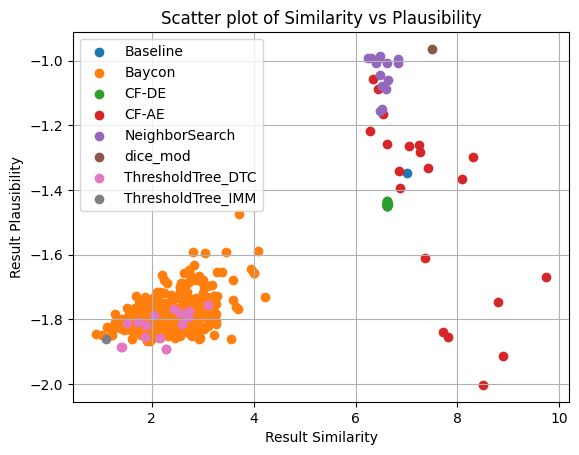

In [12]:
def plot(f1, f2, methods, results, names):
    for idx, m in enumerate(methods):
        res = results[m['name']]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x, result_y, label=f"{m['name']}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

plot(0,2, methods, results, names)

<Axes: >

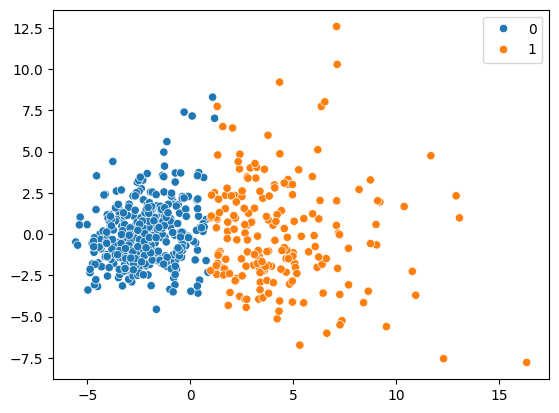

In [13]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

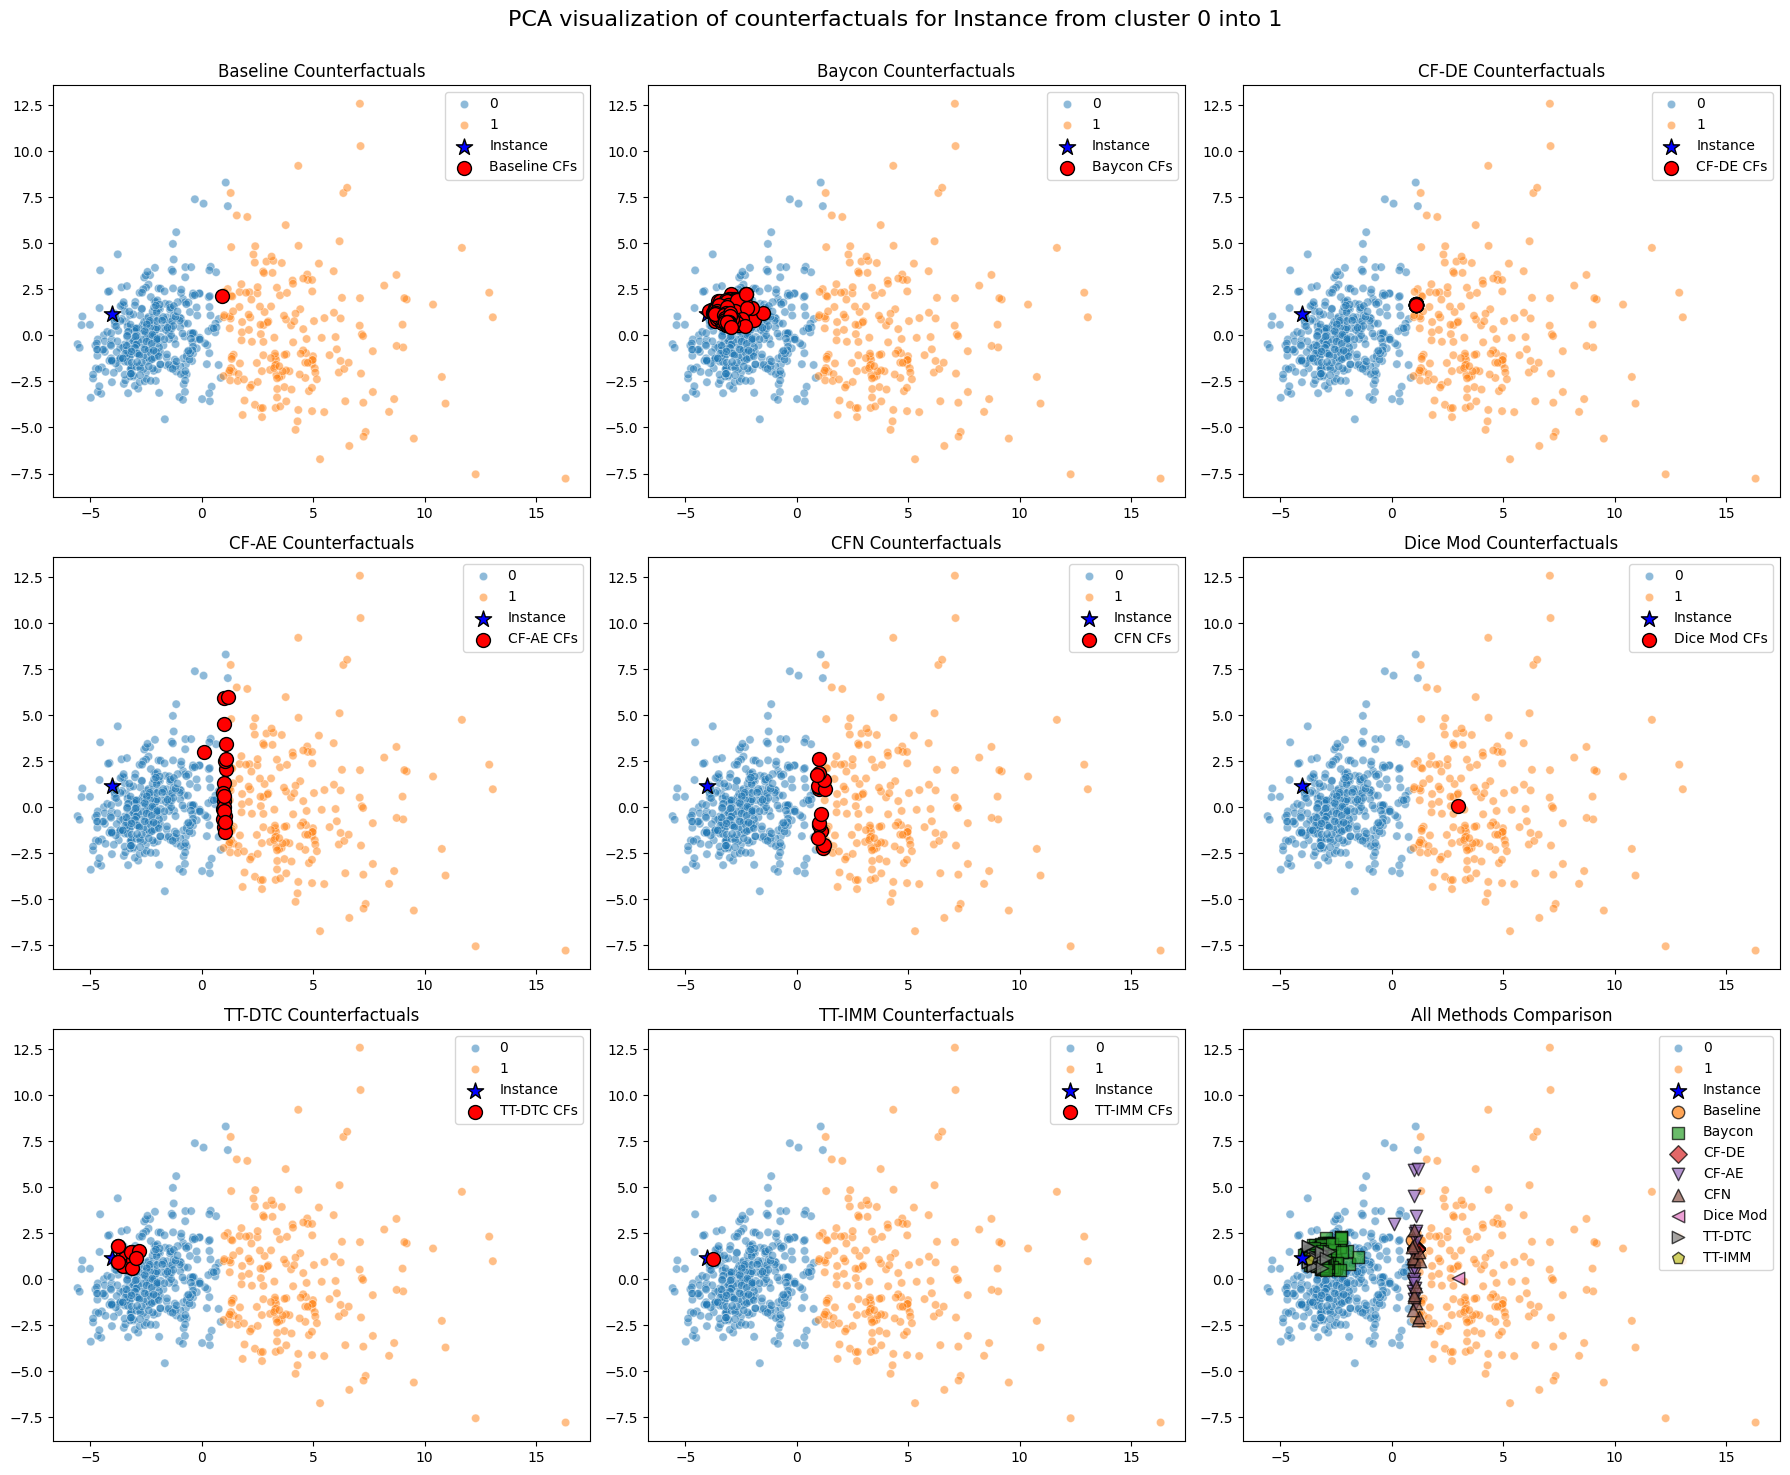

In [14]:
cf_n = 0
cf_n = 0

fig, axs = plt.subplots(3, 3, figsize=(18, 15))
axs = axs.flatten()

# Transform data with PCA
baseline_embed = pca.transform(baseline_cfs[cf_n].cf)
baycon_embed = pca.transform(baycon_cfs[cf_n].cf)
cfde_embed = pca.transform(np.array(cfde_cfs[cf_n].cf))
cfae_embed = pca.transform(np.array(cfae_cfs[cf_n].cf))
cfn_embed = pca.transform(np.array(ns_cfs[cf_n].cf))
dice_embed = pca.transform(dice_cfs[cf_n].cf)
tt_dtc_embed = pca.transform(tt_dtc_cfs[cf_n].cf)
tt_imm_embed = pca.transform(tt_imm_cfs[cf_n].cf)
instance_embedded = pca.transform(X[[baseline_cfs[cf_n].instance]])

ins_c = baseline_cfs[cf_n].instance_label
target_c = baseline_cfs[cf_n].target

# Base scatterplot of the data
for i in range(8):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')

# Plot each method's counterfactuals
methods = [
    ('Baseline', baseline_embed),
    ('Baycon', baycon_embed),
    ('CF-DE', cfde_embed),
    ('CF-AE', cfae_embed),
    ('CFN', cfn_embed),
    ('Dice Mod', dice_embed),
    ('TT-DTC', tt_dtc_embed),
    ('TT-IMM', tt_imm_embed)
]

for i, (name, embed) in enumerate(methods):
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[8])
axs[8].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
markers = ['o', 's', 'D', 'v', '^', '<', '>', 'p']
for i, (name, embed) in enumerate(methods):
    axs[8].scatter(embed[:, 0], embed[:, 1], marker=markers[i], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[8].set_title("All Methods Comparison")
axs[8].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


## Running time

In [17]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0
ns_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

    timestamp = time.time()
    i_t, new_cfs_t = neighborSearch(X=X, y=y, target=target, model=km, instance_index=index, n=10)
    ns_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt
ns_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")
print(f"CFN:     {ns_rt}")


Done training classifier. Score: 1.0
--- Executing... Initial Instance: 165 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (774) CFs (0)
Re-training surrogate model with data size: 774
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (6) Unique overall (6)
Generated random instances: (3715)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 794
Best instance score 0.0000 (X 0.99802 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 794
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (200) Unique overall (206)
Generated random instances: (3700)
Predicted top: 20 Counterfactuals: 1
Found new best [ 1.78834537  0.10945395  0.14544122  0.10042781 -0.86468013  1.6878415
  0.11954211 -0.76167427 -1.08293783 -1.43711168  0.17311648 -0.27551434
  1.11151401  0.52